To graders:
I repeated some of the experiments while trying problem 1c. The results are not entirely numerically correct but the conclusions drawn do not change

In [ ]:
# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    #predir='/content/ME/My Drive/'
    predir='ME/My Drive/'
else:
    predir='Desktop/college/cmsc25025_local/MachineLearningAlgo/hw1/'
   
import torch
import numpy as np
import os
import matplotlib.pyplot as plt 


# Torch functions 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# Folder with course data
datadir=predir+'LSDA_data/'
print("TORCH.cuda", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("datadir:", datadir)
print("get_ipython:", get_ipython())
os.getcwd() 
!python --version


TORCH.cuda True
datadir: Desktop/college/cmsc25025_local/MachineLearningAlgo/hw1/LSDA_data/
get_ipython: <ipykernel.zmqshell.ZMQInteractiveShell object at 0x000001DFED7025B0>
Python 3.9.12


In [ ]:
# !watch nvidia-smi
torch.cuda.current_device()

0

### Get Mnist data and split into train validation and test

In [ ]:
def get_mnist():

    
    data=np.float64(np.load(datadir+'mnist/MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:55000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:55000])
    val_dat=data[55000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[55000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

### Get cifar10 data and split into training, validation and testing.

In [ ]:
def get_cifar():
    tr=np.float32(np.load(datadir+'CIFAR/cifar10_train.npy')).transpose(0,3,1,2)
    tr_lb=np.int32(np.load(datadir+'CIFAR/cifar10_train_labels.npy'))
    train_data=tr[0:45000]/255.
    train_labels=tr_lb[0:45000]
    val_data=tr[45000:]/255.
    val_labels=tr_lb[45000:]
    test_data=np.float32(np.load(datadir+'CIFAR/cifar10_test.npy')).transpose(0,3,1,2)
    test_data=test_data/255.
    test_labels=np.int32(np.load(datadir+'CIFAR/cifar10_test_labels.npy'))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

### Get the data 

In [ ]:
def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="cifar"):
        return(get_cifar())

### The network

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=ks)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks, padding=pars.padding)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.deeper = False
        # question 2(b)ii designing a deeper network
        if pars.deeper:
            self.deeper = True
            self.conv3 = nn.Conv2d(64, 128, kernel_size=ks, padding=pars.padding)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            self.deeper = False
        self.drop_final=nn.Dropout(pars.dropout)
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        # Apply relu to a pooled conv3d layer with a drop layer inbetween
        # only apply if we switched to deeper network
        if self.deeper:
          x = F.relu(self.pool3(self.conv3(x)))
          if self.first:
              print('conv3', x.shape)


        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        

# Run one epoch

In [ ]:
def run_epoch(net,epoch,train,pars,num=None,ttype="train"):
    
    
    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0

        for j in trange(0,n,pars.batch_size):
                
                # Transfer the batch from cpu to gpu (or do nothing if you're on a cpu)
                data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(pars.device)
                targ=torch.torch.from_numpy(y[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                
                # Implement SGD step on batch
                loss, correct = net.run_grad(data,targ) 
                
                train_loss += loss.item()
                train_correct += correct.item()
                

        train_loss /= len(y)
        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))
        return 100. * train_correct / len(y)
        
    


In [ ]:
def net_test(net,val,pars,ttype='val'):
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),pars.batch_size):
                    data=torch.from_numpy(vald[j:j+pars.batch_size]).to(device)
                    targ = torch.from_numpy(yval[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(SSS,
                    test_loss, test_correct, len(yval),
                    100. * test_correct / len(yval)))
    return 100. * test_correct / len(yval)


# Run the training. Save the model and test at the end

In [ ]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=20
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=32
        self.pool_size=2
        self.kernel_size=5
        self.mid_layer=256
        self.use_gpu=False
        self.deeper=False
        self.padding=0

pars=par()

In [ ]:
pars.__dict__

{'batch_size': 1000,
 'step_size': 0.001,
 'num_epochs': 20,
 'numtrain': 55000,
 'minimizer': 'Adam',
 'data_set': 'mnist',
 'model_name': 'model',
 'dropout': 0.0,
 'dim': 32,
 'pool_size': 2,
 'kernel_size': 5,
 'mid_layer': 256,
 'use_gpu': False,
 'deeper': False,
 'padding': 0}

In [ ]:
# use GPU when possible
def run_network(pars, save=False):
  pars.device = device
  pars.kernel_size=[5,5]
  train,val,test=get_data(data_set=pars.data_set)
  pars.inp_dim=train[0][0].shape
  # Initialize the network
  net = MNIST_Net(pars).to(pars.device)
  # Post it to the gpu if its there.
  net.to(pars.device)


  train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])
  train_error = []
  test_error = []
  for i in range(pars.num_epochs):
      # Run one epoch of training
      train_err = 100 - run_epoch(net,i,train,pars, num=pars.numtrain, ttype="train")
      # Test on validation set.
      test_err = 100 - net_test(net,val,pars)
      # question 1a
      train_error.append(train_err)
      test_error.append(test_err)

  net_test(net,test,pars,ttype="test")

  # Save the model to a file
  if save: 
    torch.save(net.state_dict(), datadir+"tmp/"+pars.model_name)
  
  net.get_acc_and_loss
  return (train_error, test_error), net

In [ ]:
(train_error, test_error), net = run_network(pars, save=True)

(70000, 784)
conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0007, Accuracy: 45411/55000 (82.57%)


Validation set: Avg. loss: 0.0001, Accuracy: 4821/5000 (96.42%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 52709/55000 (95.83%)


Validation set: Avg. loss: 0.0001, Accuracy: 4919/5000 (98.38%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53588/55000 (97.43%)


Validation set: Avg. loss: 0.0000, Accuracy: 4950/5000 (99.00%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 53904/55000 (98.01%)


Validation set: Avg. loss: 0.0000, Accuracy: 4957/5000 (99.14%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 54142/55000 (98.44%)


Validation set: Avg. loss: 0.0000, Accuracy: 4960/5000 (99.20%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54244/55000 (98.63%)


Validation set: Avg. loss: 0.0000, Accuracy: 4964/5000 (99.28%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54377/55000 (98.87%)


Validation set: Avg. loss: 0.0000, Accuracy: 4967/5000 (99.34%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54449/55000 (99.00%)


Validation set: Avg. loss: 0.0000, Accuracy: 4970/5000 (99.40%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54499/55000 (99.09%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54579/55000 (99.23%)


Validation set: Avg. loss: 0.0000, Accuracy: 4971/5000 (99.42%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 54625/55000 (99.32%)


Validation set: Avg. loss: 0.0000, Accuracy: 4971/5000 (99.42%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 54668/55000 (99.40%)


Validation set: Avg. loss: 0.0000, Accuracy: 4974/5000 (99.48%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 54714/55000 (99.48%)


Validation set: Avg. loss: 0.0000, Accuracy: 4974/5000 (99.48%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 54766/55000 (99.57%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 54737/55000 (99.52%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 54788/55000 (99.61%)


Validation set: Avg. loss: 0.0000, Accuracy: 4971/5000 (99.42%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 54813/55000 (99.66%)


Validation set: Avg. loss: 0.0000, Accuracy: 4981/5000 (99.62%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 54850/55000 (99.73%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 54858/55000 (99.74%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 54874/55000 (99.77%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)


Test set: Avg. loss: 0.0000, Accuracy: 9910/10000 (99.10%)



In [ ]:
# Question 2a plotting the training accuracies vs testing accuracies
def plot_error_rate(train_error, test_error):
  plt.plot(train_error, label='Training Error rate as a function of epoch')
  plt.plot(test_error, label='Testing Error rate as a function of epoch')
  plt.legend(loc='best')
  plt.title('Training Error rate vs Testing Error rate')
  plt.show()


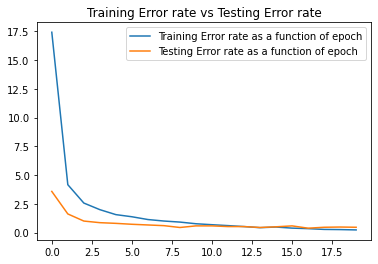

In [ ]:
plot_error_rate(train_error, test_error)

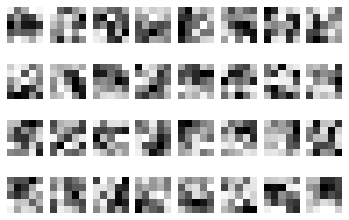

In [ ]:
# question 1a
# printing the filters used in the first layer of the model
filters = net.conv1.weight.cpu().detach().numpy()
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(filters[i][0], cmap = 'gray')
    plt.axis('off')
plt.show()



(70000, 784)
conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([128, 1024])
fc1.bias torch.Size([128])
fc_final.weight torch.Size([10, 128])
fc_final.bias torch.Size([10])
tot_pars 184586


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0008, Accuracy: 44296/55000 (80.54%)


Validation set: Avg. loss: 0.0001, Accuracy: 4788/5000 (95.76%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0002, Accuracy: 52260/55000 (95.02%)


Validation set: Avg. loss: 0.0001, Accuracy: 4894/5000 (97.88%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53339/55000 (96.98%)


Validation set: Avg. loss: 0.0000, Accuracy: 4939/5000 (98.78%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 53780/55000 (97.78%)


Validation set: Avg. loss: 0.0000, Accuracy: 4957/5000 (99.14%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 54025/55000 (98.23%)


Validation set: Avg. loss: 0.0000, Accuracy: 4955/5000 (99.10%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0001, Accuracy: 54178/55000 (98.51%)


Validation set: Avg. loss: 0.0000, Accuracy: 4965/5000 (99.30%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54248/55000 (98.63%)


Validation set: Avg. loss: 0.0000, Accuracy: 4966/5000 (99.32%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54350/55000 (98.82%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54467/55000 (99.03%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54510/55000 (99.11%)


Validation set: Avg. loss: 0.0000, Accuracy: 4970/5000 (99.40%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 54565/55000 (99.21%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 54539/55000 (99.16%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 54631/55000 (99.33%)


Validation set: Avg. loss: 0.0000, Accuracy: 4979/5000 (99.58%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 54652/55000 (99.37%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 54711/55000 (99.47%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 54724/55000 (99.50%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 54720/55000 (99.49%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 54743/55000 (99.53%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 54776/55000 (99.59%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 54830/55000 (99.69%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)


Test set: Avg. loss: 0.0000, Accuracy: 9903/10000 (99.03%)



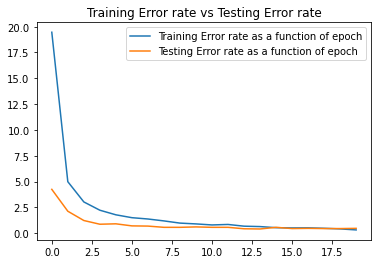

In [ ]:
# question 2b
# i. keep same number of layers and change layer parameters
#     reduce number of prarameters by half


pars_half = par()
pars_half.mid_layer = 128
(train_error, test_error), _ = run_network(pars_half, save=False)
plot_error_rate(train_error, test_error)



(70000, 784)
conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0006, Accuracy: 45441/55000 (82.62%)


Validation set: Avg. loss: 0.0001, Accuracy: 4821/5000 (96.42%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0002, Accuracy: 52466/55000 (95.39%)


Validation set: Avg. loss: 0.0001, Accuracy: 4915/5000 (98.30%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53503/55000 (97.28%)


Validation set: Avg. loss: 0.0000, Accuracy: 4933/5000 (98.66%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 53857/55000 (97.92%)


Validation set: Avg. loss: 0.0000, Accuracy: 4952/5000 (99.04%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 54062/55000 (98.29%)


Validation set: Avg. loss: 0.0000, Accuracy: 4964/5000 (99.28%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54276/55000 (98.68%)


Validation set: Avg. loss: 0.0000, Accuracy: 4967/5000 (99.34%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54337/55000 (98.79%)


Validation set: Avg. loss: 0.0000, Accuracy: 4973/5000 (99.46%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54427/55000 (98.96%)


Validation set: Avg. loss: 0.0000, Accuracy: 4965/5000 (99.30%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54439/55000 (98.98%)


Validation set: Avg. loss: 0.0000, Accuracy: 4967/5000 (99.34%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54525/55000 (99.14%)


Validation set: Avg. loss: 0.0000, Accuracy: 4968/5000 (99.36%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 54588/55000 (99.25%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 54628/55000 (99.32%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 54688/55000 (99.43%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 54730/55000 (99.51%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 54701/55000 (99.46%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 54785/55000 (99.61%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 54771/55000 (99.58%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 54842/55000 (99.71%)


Validation set: Avg. loss: 0.0000, Accuracy: 4968/5000 (99.36%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 54824/55000 (99.68%)


Validation set: Avg. loss: 0.0000, Accuracy: 4981/5000 (99.62%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 54849/55000 (99.73%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)


Test set: Avg. loss: 0.0000, Accuracy: 9918/10000 (99.18%)



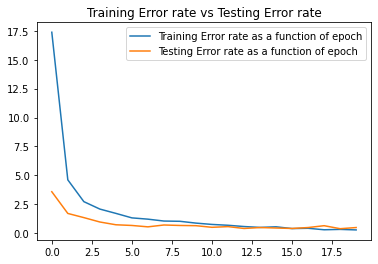

In [ ]:
#     double the number of parameters 
pars_double = par()
pars_half.mid_layer = 512
(train_error, test_error), _ = run_network(pars_double, save=False)
plot_error_rate(train_error, test_error)

It seems to me that changing the layer parameters by reducing to half and doubling does not change the result to much. I recorded one execution (reulsts may be different than the final version) and got
For doubling, we have the accuracy 9902/10000(99.02%). \\
For halving, the accuracy is 9905/10000 (99.05%). \\
For the original mode, the accuracy is 9914/10000 (99.14%)\\
In short, there is not a significant change in accuracies since they are all around 99%. 

(70000, 784)
conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 9, 9])
conv3 torch.Size([1, 128, 7, 7])
input dimension to fc1 6272
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 5, 5])
conv3.bias torch.Size([128])
fc1.weight torch.Size([512, 6272])
fc1.bias torch.Size([512])
fc_final.weight torch.Size([10, 512])
fc_final.bias torch.Size([10])
tot_pars 3473930


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0006, Accuracy: 43790/55000 (79.62%)


Validation set: Avg. loss: 0.0001, Accuracy: 4885/5000 (97.70%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 53319/55000 (96.94%)


Validation set: Avg. loss: 0.0000, Accuracy: 4947/5000 (98.94%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53892/55000 (97.99%)


Validation set: Avg. loss: 0.0000, Accuracy: 4952/5000 (99.04%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 54247/55000 (98.63%)


Validation set: Avg. loss: 0.0000, Accuracy: 4969/5000 (99.38%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54309/55000 (98.74%)


Validation set: Avg. loss: 0.0000, Accuracy: 4969/5000 (99.38%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54470/55000 (99.04%)


Validation set: Avg. loss: 0.0000, Accuracy: 4974/5000 (99.48%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54526/55000 (99.14%)


Validation set: Avg. loss: 0.0000, Accuracy: 4974/5000 (99.48%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54698/55000 (99.45%)


Validation set: Avg. loss: 0.0000, Accuracy: 4973/5000 (99.46%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54628/55000 (99.32%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54731/55000 (99.51%)


Validation set: Avg. loss: 0.0000, Accuracy: 4985/5000 (99.70%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 54787/55000 (99.61%)


Validation set: Avg. loss: 0.0000, Accuracy: 4984/5000 (99.68%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 54822/55000 (99.68%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 54833/55000 (99.70%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 54865/55000 (99.75%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 54899/55000 (99.82%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 54815/55000 (99.66%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 54885/55000 (99.79%)


Validation set: Avg. loss: 0.0000, Accuracy: 4983/5000 (99.66%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 54933/55000 (99.88%)


Validation set: Avg. loss: 0.0000, Accuracy: 4985/5000 (99.70%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 54934/55000 (99.88%)


Validation set: Avg. loss: 0.0000, Accuracy: 4979/5000 (99.58%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 54957/55000 (99.92%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)


Test set: Avg. loss: 0.0000, Accuracy: 9922/10000 (99.22%)



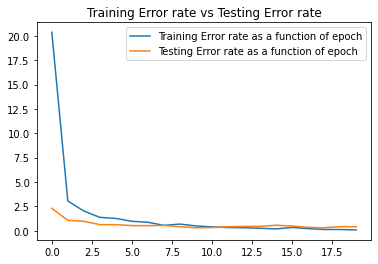

In [ ]:
# question 2(b)ii
pars_deeper = par()
pars_deeper.deeper = True
pars_deeper.mid_layer = 512
pars_deeper.padding = 5
(train_error, test_error), net_deeper = run_network(pars_deeper, save=False)
plot_error_rate(train_error, test_error)


Report (2bii, 2biii):

We can see that the deeper network's accuracy is not very different from the original model as well, since 9900/10000 (99.00%) is roughly the same as 9919/10000 (99.19%), so there is no significant improvement (for one execution). The final result that I submit may differ but they are all around 99% with less than 0.5% variation. 
Note that I implemented the network on all training data.

# Reload the model that was saved and continue training

In [ ]:
train,val,test=get_data(data_set=pars.data_set)
pars.new_model_name = 'model_continue'
pars.inp_dim=train[0][0].shape
net = MNIST_Net(pars).to(pars.device)

print(pars.__dict__)
state_dict = torch.load(datadir+'tmp/'+pars.model_name, map_location = 'cpu')
net.load_state_dict(state_dict)
net.eval()
for i in range(pars.num_epochs):
    run_epoch(net,i,train,pars, num=pars.numtrain, ttype="train")
    net_test(net,val,pars)

net_test(net,test,pars, ttype="test")
#save model
torch.save(net.state_dict(), datadir+"tmp/"+pars.model_name)

(70000, 784)
conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066
{'batch_size': 1000, 'step_size': 0.001, 'num_epochs': 20, 'numtrain': 55000, 'minimizer': 'Adam', 'data_set': 'mnist', 'model_name': 'model', 'dropout': 0.0, 'dim': 32, 'pool_size': 2, 'kernel_size': [5, 5], 'mid_layer': 256, 'use_gpu': False, 'deeper': False, 'padding': 0, 'device': device(type='cuda', index=0), 'inp_dim': (1, 28, 28), 'new_model_name': 'model_continue'}


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0000, Accuracy: 54670/55000 (99.40%)


Validation set: Avg. loss: 0.0000, Accuracy: 4983/5000 (99.66%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0000, Accuracy: 54891/55000 (99.80%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0000, Accuracy: 54932/55000 (99.88%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 54890/55000 (99.80%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54926/55000 (99.87%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54944/55000 (99.90%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54911/55000 (99.84%)


Validation set: Avg. loss: 0.0000, Accuracy: 4969/5000 (99.38%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54929/55000 (99.87%)


Validation set: Avg. loss: 0.0000, Accuracy: 4965/5000 (99.30%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54896/55000 (99.81%)


Validation set: Avg. loss: 0.0000, Accuracy: 4974/5000 (99.48%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54946/55000 (99.90%)


Validation set: Avg. loss: 0.0000, Accuracy: 4983/5000 (99.66%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 54977/55000 (99.96%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 54958/55000 (99.92%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 54953/55000 (99.91%)


Validation set: Avg. loss: 0.0000, Accuracy: 4971/5000 (99.42%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 54960/55000 (99.93%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 54968/55000 (99.94%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 54945/55000 (99.90%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 54956/55000 (99.92%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 54967/55000 (99.94%)


Validation set: Avg. loss: 0.0000, Accuracy: 4974/5000 (99.48%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 54971/55000 (99.95%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 54994/55000 (99.99%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)


Test set: Avg. loss: 0.0000, Accuracy: 9925/10000 (99.25%)



### Shift the mnist data randomly in both coordinates and create new perturbed test set.


In [ ]:
import pylab as py
def get_mnist_trans(test,shift):
    ll=test.shape[0]
    shift2=shift//2
    uu=np.int32((np.random.rand(ll,2)-.5)*shift)
    test_t=[]
    for i,t in enumerate(test):
        tt=np.zeros((28+shift+1,28+shift+1))
        tt[shift2:shift2+28,shift2:shift2+28]=t
        ttt=tt[shift2+uu[i,0]:shift2+uu[i,0]+28,shift2+uu[i,1]:shift2+uu[i,1]+28]
        test_t.append(ttt.reshape(1,28,28))
    test_labels=np.int32(np.load(datadir+'mnist/MNIST_labels.npy'))
    test_trans_dat=np.float32(np.concatenate(test_t,axis=0).reshape((-1,1,28,28)))
    for j in range(20):
      py.subplot(1,20,j+1)
      py.imshow(test_trans_dat[j,0])
      py.axis('off')
    py.show()
    print(test_trans_dat.shape)
    return (test_trans_dat, test_labels[60000:])

(70000, 784)
conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0000, Accuracy: 9925/10000 (99.25%)

conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0000, Accuracy: 9925/10000 (99.25%)

conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0001, Accuracy: 9890/10000 (98.90%)

conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0002, Accuracy: 9647/10000 (96.47%)

conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0008, Accuracy: 8878/10000 (88.78%)

conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0023, Accuracy: 7533/10000 (75.33%)

conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0045, Accuracy: 6274/10000 (62.74%)

conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 4, 4])
input dimension to fc1 1024
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1024])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 317066


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0066, Accuracy: 5198/10000 (51.98%)



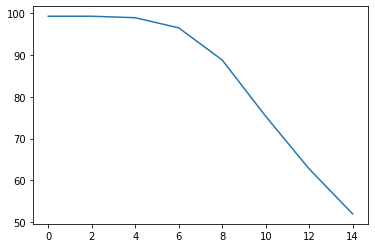

In [ ]:
# 2c apply the original mode lto shifted data for different sizes
# plot the classification rate as a function of shift
train, val, test = get_data(data_set=pars.data_set)
accuracies = []

for i in range(0,16,2):
    net = MNIST_Net(pars).to(pars.device)
    test_sfhited = get_mnist_trans(test[0],i)
    
    state_dict = torch.load(datadir+'tmp/'+pars.model_name, map_location = 'cpu')
    net.load_state_dict(state_dict)
    accuracies.append(net_test(net,test_sfhited, pars, ttype="test"))

plt.plot(range(0,16,2), accuracies)
plt.show()
  



(70000, 784)
(70000, 784)
conv1 torch.Size([1, 32, 12, 12])
conv2 torch.Size([1, 64, 9, 9])
conv3 torch.Size([1, 128, 7, 7])
input dimension to fc1 6272
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 5, 5])
conv3.bias torch.Size([128])
fc1.weight torch.Size([256, 6272])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1865482


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0007, Accuracy: 42505/55000 (77.28%)


Validation set: Avg. loss: 0.0001, Accuracy: 4845/5000 (96.90%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 52931/55000 (96.24%)


Validation set: Avg. loss: 0.0000, Accuracy: 4924/5000 (98.48%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53725/55000 (97.68%)


Validation set: Avg. loss: 0.0000, Accuracy: 4957/5000 (99.14%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 54157/55000 (98.47%)


Validation set: Avg. loss: 0.0000, Accuracy: 4961/5000 (99.22%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54274/55000 (98.68%)


Validation set: Avg. loss: 0.0000, Accuracy: 4968/5000 (99.36%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54420/55000 (98.95%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54545/55000 (99.17%)


Validation set: Avg. loss: 0.0000, Accuracy: 4972/5000 (99.44%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54624/55000 (99.32%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54641/55000 (99.35%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54723/55000 (99.50%)


Validation set: Avg. loss: 0.0000, Accuracy: 4975/5000 (99.50%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0000, Accuracy: 54755/55000 (99.55%)


Validation set: Avg. loss: 0.0000, Accuracy: 4978/5000 (99.56%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0000, Accuracy: 54803/55000 (99.64%)


Validation set: Avg. loss: 0.0000, Accuracy: 4973/5000 (99.46%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0000, Accuracy: 54794/55000 (99.63%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0000, Accuracy: 54866/55000 (99.76%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 54815/55000 (99.66%)


Validation set: Avg. loss: 0.0000, Accuracy: 4979/5000 (99.58%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 54799/55000 (99.63%)


Validation set: Avg. loss: 0.0000, Accuracy: 4980/5000 (99.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 54895/55000 (99.81%)


Validation set: Avg. loss: 0.0000, Accuracy: 4977/5000 (99.54%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 54931/55000 (99.87%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 54931/55000 (99.87%)


Validation set: Avg. loss: 0.0000, Accuracy: 4976/5000 (99.52%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 54926/55000 (99.87%)


Validation set: Avg. loss: 0.0000, Accuracy: 4983/5000 (99.66%)


Test set: Avg. loss: 0.0000, Accuracy: 9915/10000 (99.15%)



(10000, 1, 28, 28)

Test set: Avg. loss: 0.0000, Accuracy: 9915/10000 (99.15%)



(10000, 1, 28, 28)

Test set: Avg. loss: 0.0000, Accuracy: 9915/10000 (99.15%)



(10000, 1, 28, 28)

Test set: Avg. loss: 0.0001, Accuracy: 9882/10000 (98.82%)



(10000, 1, 28, 28)

Test set: Avg. loss: 0.0001, Accuracy: 9760/10000 (97.60%)



(10000, 1, 28, 28)

Test set: Avg. loss: 0.0003, Accuracy: 9373/10000 (93.73%)



(10000, 1, 28, 28)

Test set: Avg. loss: 0.0009, Accuracy: 8543/10000 (85.43%)



(10000, 1, 28, 28)

Test set: Avg. loss: 0.0020, Accuracy: 7448/10000 (74.48%)



(10000, 1, 28, 28)

Test set: Avg. loss: 0.0032, Accuracy: 6335/10000 (63.35%)



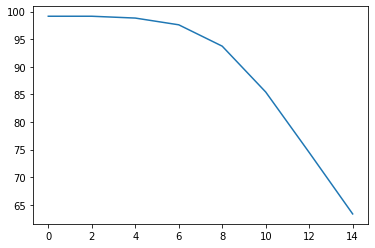

In [ ]:
train, val, test = get_data(data_set=pars.data_set)


pars_deep=par()
pars_deep.model_name = "deeper"
pars_deep.num_epochs = 20
pars_deep.deeper = True
pars_deep.padding = 5
(_ , _), net_deep = run_network(pars_deep, save=False)

accuracies2 = []

for i in range(0,16,2):
    test_sfhited2 = get_mnist_trans(test[0],i)
    result = net_test(net_deep, test_sfhited2, pars_deep, ttype="test")
    accuracies2.append(result)


plt.plot(range(0,16,2), accuracies2)
plt.show()

Once I switched to the deeper network, there is a significant increase in the validation accuracy(>10%). I added another layer as what I did in 2bii. 

Question3 starts from here. If it gets buggy, please copy paste the second half to a standalone ipynb. Thank you!!

In [ ]:
# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    #predir='/content/ME/My Drive/'
    predir='ME/My Drive/'
else:
    predir='Desktop/college/cmsc25025_local/MachineLearningAlgo/hw1/'
   
import torch
import numpy as np
import os
import matplotlib.pyplot as plt 


# Torch functions 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# Folder with course data
datadir=predir+'LSDA_data/'
print("TORCH.cuda", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("datadir:", datadir)
print("get_ipython:", get_ipython())
os.getcwd() 
!python --version


Mounted at ME
TORCH.cuda True
datadir: ME/My Drive/LSDA_data/
get_ipython: <google.colab._shell.Shell object at 0x7f0a2a520b10>
Python 3.7.13


In [ ]:
torch.cuda.current_device()

0

In [ ]:
def get_mnist():

    
    data=np.float64(np.load(datadir+'mnist/MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:55000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:55000])
    val_dat=data[55000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[55000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [ ]:
# def get_cifar():
#     tr=np.float32(np.load(datadir+'CIFAR/cifar10_train.npy', allow_pickle=True)).transpose(0,3,1,2)
#     tr_lb=np.int32(np.load(datadir+'CIFAR/cifar10_train_labels.npy', allow_pickle=True))
#     train_data=tr[0:45000]/255.
#     train_labels=tr_lb[0:45000]
#     val_data=tr[45000:]/255.
#     val_labels=tr_lb[45000:]
#     test_data=np.float32(np.load(datadir+'CIFAR/cifar10_test.npy', allow_pickle=True)).transpose(0,3,1,2)
#     test_data=test_data/255.
#     test_labels=np.int32(np.load(datadir+'CIFAR/cifar10_test_labels.npy', allow_pickle=True))
#     return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

import h5py

def get_cifar():
    with h5py.File(datadir+'CIFAR/cifar10_train.hdf5', "r") as f:
        tr=np.float32(f[('data')][:]).transpose(0,3,1,2)
        tr_lb=np.float32(f[('labels')])[:]
    train_data=tr[0:45000]/255.
    train_labels=tr_lb[0:45000]
    val_data=tr[45000:]/255.
    val_labels=tr_lb[45000:]
    
    with h5py.File(datadir+'CIFAR/cifar10_test.hdf5', "r") as f:
        test_data=np.float32(f[('data')][:]).transpose(0,3,1,2)
        test_data=test_data/255.
        test_labels=np.float32(f[('labels')])[:]
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

In [ ]:
def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="cifar"):
        return(get_cifar())

In [ ]:
class CIFAR_Net(nn.Module):
    def __init__(self,pars):
        super(CIFAR_Net, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=[ps])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks, padding=pars.padding)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=[ps])
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.deeper = False
        # question 1(b)ii designing a deeper network
        if pars.deeper:
            self.deeper = True
            self.conv3 = nn.Conv2d(64, 128, kernel_size=ks, padding=pars.padding)
            self.pool3 = nn.MaxPool2d(kernel_size=[ps], stride=[ps])
        else:
            self.deeper = False
        self.drop_final=nn.Dropout(pars.dropout)
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        if self.deeper:
          x = F.relu(self.pool3(self.conv3(x)))
          if self.first:
              print('conv3', x.shape)


        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        

In [ ]:
def run_epoch(net,epoch,train,pars,num=None,ttype="train"):
    
    
    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0

        for j in trange(0,n,pars.batch_size):
                
                # Transfer the batch from cpu to gpu (or do nothing if you're on a cpu)
                data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(pars.device)
                targ=torch.torch.from_numpy(y[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                
                # Implement SGD step on batch
                loss, correct = net.run_grad(data,targ) 
                
                train_loss += loss.item()
                train_correct += correct.item()
                

        train_loss /= len(y)
        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))
        return 100. * train_correct / len(y)
        
    


In [ ]:
def net_test(net,val,pars,ttype='val'):
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),pars.batch_size):
                    data=torch.from_numpy(vald[j:j+pars.batch_size]).to(device)
                    targ = torch.from_numpy(yval[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(SSS,
                    test_loss, test_correct, len(yval),
                    100. * test_correct / len(yval)))
    return 100. * test_correct / len(yval)


In [ ]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=20
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="cifar"
        self.model_name="model"
        self.dropout=0.
        self.dim=32
        self.pool_size=2
        self.kernel_size=5
        self.mid_layer=256
        self.use_gpu=False
        self.deeper=False
        self.padding=0

pars=par()

In [ ]:
# use GPU when possible
def run_network(pars, save=False):
  pars.device = device
  pars.kernel_size=[5,5]
  train,val,test=get_data(data_set=pars.data_set)
  pars.inp_dim=train[0][0].shape
  # Initialize the network
  net = CIFAR_Net(pars).to(pars.device)
  # Post it to the gpu if its there.
  net.to(pars.device)


  train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])
  train_error = []
  test_error = []
  for i in range(pars.num_epochs):
      # Run one epoch of training
      train_err = 100 - run_epoch(net,i,train,pars, num=pars.numtrain, ttype="train")
      # Test on validation set.
      test_err = 100 - net_test(net,val,pars)
      # question 1a
      train_error.append(train_err)
      test_error.append(test_err)

  net_test(net,test,pars,ttype="test")

  # Save the model to a file
  if save: 
    torch.save(net.state_dict(), datadir+"tmp/"+pars.model_name)
  
  net.get_acc_and_loss
  return (train_error, test_error), net

In [ ]:
def plot_error_rate(train_error, test_error):
  plt.plot(train_error, label='Training Error rate as a function of epoch')
  plt.plot(test_error, label='Testing Error rate as a function of epoch')
  plt.legend(loc='best')
  plt.title('Training Error rate vs Testing Error rate')
  plt.show()

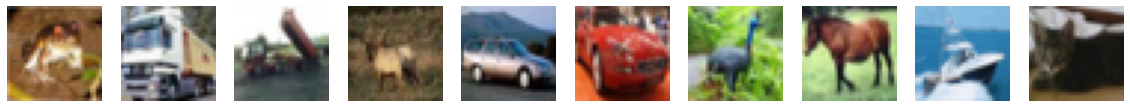

In [ ]:
# question 3a
pars = par()
(train, label), _, _ = get_data(pars.data_set)

def show(data, label):
    plt.figure(figsize=(20,20))
    for i in range(10):
        image = data[i] * 255
        image = image.reshape(3,32,32).transpose(1,2,0).astype("uint8")
        plt.subplot(1,10,i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

show(train, label)

In [ ]:
# question 3b
(train_error, test_error), net = run_network(pars, save=True)

conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 5, 5])
input dimension to fc1 1600
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1600])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 466122


  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0020, Accuracy: 13176/45000 (29.28%)


Validation set: Avg. loss: 0.0017, Accuracy: 1913/5000 (38.26%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0017, Accuracy: 18055/45000 (40.12%)


Validation set: Avg. loss: 0.0016, Accuracy: 2148/5000 (42.96%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0015, Accuracy: 19960/45000 (44.36%)


Validation set: Avg. loss: 0.0015, Accuracy: 2343/5000 (46.86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0014, Accuracy: 21572/45000 (47.94%)


Validation set: Avg. loss: 0.0014, Accuracy: 2496/5000 (49.92%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0014, Accuracy: 22810/45000 (50.69%)


Validation set: Avg. loss: 0.0014, Accuracy: 2555/5000 (51.10%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0013, Accuracy: 23732/45000 (52.74%)


Validation set: Avg. loss: 0.0013, Accuracy: 2731/5000 (54.62%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0013, Accuracy: 24372/45000 (54.16%)


Validation set: Avg. loss: 0.0013, Accuracy: 2750/5000 (55.00%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0012, Accuracy: 25186/45000 (55.97%)


Validation set: Avg. loss: 0.0012, Accuracy: 2863/5000 (57.26%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0012, Accuracy: 26016/45000 (57.81%)


Validation set: Avg. loss: 0.0012, Accuracy: 2858/5000 (57.16%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0012, Accuracy: 26687/45000 (59.30%)


Validation set: Avg. loss: 0.0011, Accuracy: 2990/5000 (59.80%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0011, Accuracy: 27281/45000 (60.62%)


Validation set: Avg. loss: 0.0011, Accuracy: 3063/5000 (61.26%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0011, Accuracy: 27795/45000 (61.77%)


Validation set: Avg. loss: 0.0011, Accuracy: 3070/5000 (61.40%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0011, Accuracy: 28280/45000 (62.84%)


Validation set: Avg. loss: 0.0011, Accuracy: 3081/5000 (61.62%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0010, Accuracy: 28744/45000 (63.88%)


Validation set: Avg. loss: 0.0011, Accuracy: 3081/5000 (61.62%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0010, Accuracy: 29065/45000 (64.59%)


Validation set: Avg. loss: 0.0010, Accuracy: 3162/5000 (63.24%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0010, Accuracy: 29164/45000 (64.81%)


Validation set: Avg. loss: 0.0010, Accuracy: 3222/5000 (64.44%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0010, Accuracy: 29722/45000 (66.05%)


Validation set: Avg. loss: 0.0010, Accuracy: 3233/5000 (64.66%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0009, Accuracy: 30188/45000 (67.08%)


Validation set: Avg. loss: 0.0010, Accuracy: 3281/5000 (65.62%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0009, Accuracy: 30368/45000 (67.48%)


Validation set: Avg. loss: 0.0010, Accuracy: 3297/5000 (65.94%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0009, Accuracy: 30833/45000 (68.52%)


Validation set: Avg. loss: 0.0009, Accuracy: 3351/5000 (67.02%)


Test set: Avg. loss: 0.0010, Accuracy: 6627/10000 (66.27%)



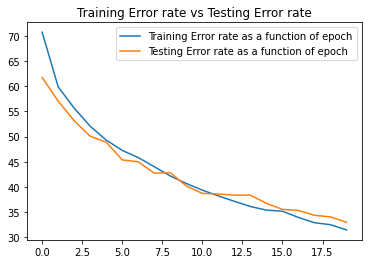

In [ ]:
plot_error_rate(train_error, test_error)

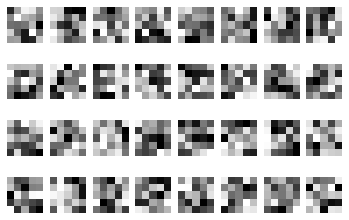

In [ ]:
# question3a filters
filters = net.conv1.weight.cpu().detach().numpy()
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(filters[i][0], cmap = 'gray')
    plt.axis('off')
plt.show()

conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 10, 10])
conv3 torch.Size([1, 128, 8, 8])
input dimension to fc1 8192
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 5, 5])
conv3.bias torch.Size([128])
fc1.weight torch.Size([512, 8192])
fc1.bias torch.Size([512])
fc_final.weight torch.Size([10, 512])
fc_final.bias torch.Size([10])
tot_pars 4458570


  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0019, Accuracy: 13096/45000 (29.10%)


Validation set: Avg. loss: 0.0017, Accuracy: 1905/5000 (38.10%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0015, Accuracy: 19972/45000 (44.38%)


Validation set: Avg. loss: 0.0014, Accuracy: 2443/5000 (48.86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0014, Accuracy: 22802/45000 (50.67%)


Validation set: Avg. loss: 0.0013, Accuracy: 2642/5000 (52.84%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0013, Accuracy: 24612/45000 (54.69%)


Validation set: Avg. loss: 0.0012, Accuracy: 2788/5000 (55.76%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0011, Accuracy: 26450/45000 (58.78%)


Validation set: Avg. loss: 0.0011, Accuracy: 3015/5000 (60.30%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0011, Accuracy: 27854/45000 (61.90%)


Validation set: Avg. loss: 0.0011, Accuracy: 3108/5000 (62.16%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0010, Accuracy: 28934/45000 (64.30%)


Validation set: Avg. loss: 0.0010, Accuracy: 3241/5000 (64.82%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0009, Accuracy: 30255/45000 (67.23%)


Validation set: Avg. loss: 0.0010, Accuracy: 3287/5000 (65.74%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0009, Accuracy: 31096/45000 (69.10%)


Validation set: Avg. loss: 0.0009, Accuracy: 3308/5000 (66.16%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0008, Accuracy: 32074/45000 (71.28%)


Validation set: Avg. loss: 0.0009, Accuracy: 3397/5000 (67.94%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0008, Accuracy: 32782/45000 (72.85%)


Validation set: Avg. loss: 0.0009, Accuracy: 3506/5000 (70.12%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0007, Accuracy: 33731/45000 (74.96%)


Validation set: Avg. loss: 0.0008, Accuracy: 3576/5000 (71.52%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0007, Accuracy: 34374/45000 (76.39%)


Validation set: Avg. loss: 0.0008, Accuracy: 3590/5000 (71.80%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0006, Accuracy: 34780/45000 (77.29%)


Validation set: Avg. loss: 0.0008, Accuracy: 3574/5000 (71.48%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0006, Accuracy: 35452/45000 (78.78%)


Validation set: Avg. loss: 0.0008, Accuracy: 3598/5000 (71.96%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0006, Accuracy: 36362/45000 (80.80%)


Validation set: Avg. loss: 0.0008, Accuracy: 3672/5000 (73.44%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0005, Accuracy: 36993/45000 (82.21%)


Validation set: Avg. loss: 0.0008, Accuracy: 3638/5000 (72.76%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0005, Accuracy: 37371/45000 (83.05%)


Validation set: Avg. loss: 0.0009, Accuracy: 3513/5000 (70.26%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0004, Accuracy: 38132/45000 (84.74%)


Validation set: Avg. loss: 0.0008, Accuracy: 3650/5000 (73.00%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0004, Accuracy: 38366/45000 (85.26%)


Validation set: Avg. loss: 0.0008, Accuracy: 3687/5000 (73.74%)


Test set: Avg. loss: 0.0008, Accuracy: 7309/10000 (73.09%)



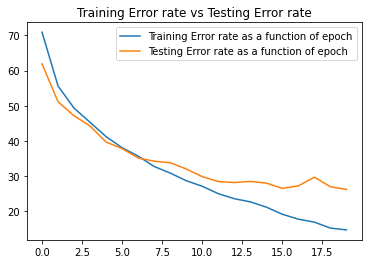

In [ ]:
# question3c deeper network
pars_deeper = par()
pars_deeper.model_name = "deeper"
pars_deeper.deeper = True
pars_deeper.padding = 5
pars_deeper.mid_layer = 512
(train_error_deep, test_error_deep), net_deep = run_network(pars_deeper, save=True)
plot_error_rate(train_error_deep, test_error_deep)

We can clearly tell that there is a significant increase in the accuracies.(from around 64 to 74) (again number may change depending on the epoch, but the general increase trend holds)

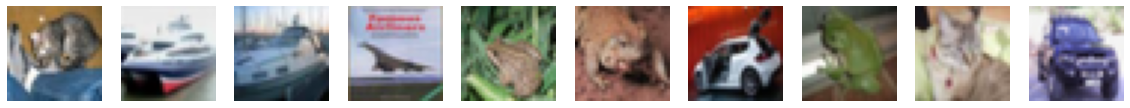

In [ ]:
# question 3d
from skimage import color
import random

_, _, (test_data, test_label) = get_cifar()
images = test_data * 255

# handling variablity. Use skimage.color.rgb2hsv to transform the rgb color map of the input images to hsv






# multiply the saturation of all pixels by the random value (not exeeding [0,1])
images = images.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")

def randomize (image, random):
  image = color.rgb2hsv(image)
  image[:,:,1] = np.clip(image[:,:,1] * random.uniform(0.75,1.25), 0 ,1)
  # generate a random value between 0.75 and 1.25
  return image

modified_images = np.array([randomize(image, random) for image in images])
modified_images = modified_images.reshape(10000,32,32,3)


# modified_image = []
# for image in images:
#     image = color.rgb2hsv(image)
#     image[:,:,1] = np.clip(image[:,:,1] * random, 0, 1)
#     modified_image.append(image)
# modified_image = np.array(modified_image).reshape(10000, 32,32,3)




# convert back to RGB
modified_image_back = np.array([color.hsv2rgb(image) for image in modified_images]).reshape(10000,32,32,3)


# modified_image_back = []
# for image in modified_image:
#     image = color.hsv2rgb(image)
#     modified_image_back.append(image)
# modified_image_back = np.array(modified_image_back).reshape(10000,32,32,3)
modified_image_back = np.float32(modified_image_back.transpose(0,3,1,2))



# show resulting images
show(modified_image_back, test_label)


In [ ]:
# run the model on the modified data and report the result
net = CIFAR_Net(pars).to(pars.device)
state_dict = torch.load(datadir+'tmp/'+pars.model_name, map_location = 'cpu')

net.load_state_dict(state_dict)
net_test(net, (modified_image_back, test_label), pars, ttype="test")


net_deep = CIFAR_Net(pars_deeper).to(pars_deeper.device)
state_dict_deeper = torch.load(datadir+'tmp/'+pars_deeper.model_name, map_location = 'cpu')
net_deep.load_state_dict(state_dict_deeper)
net_test(net_deep, (modified_image_back, test_label), pars, ttype="test")




conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 5, 5])
input dimension to fc1 1600
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 1600])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 466122

Test set: Avg. loss: 0.0010, Accuracy: 6613/10000 (66.13%)

conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 10, 10])
conv3 torch.Size([1, 128, 8, 8])
input dimension to fc1 8192
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 5, 5])
conv3.bias torch.Size([128])
fc1.weight torch.Size([512, 8192])
fc1.bias torch.Size([512])
fc_final.weight torch.Size([10, 512])
fc_final.bias torch.Size([10])
tot_pars 4458570

Test set: Avg. loss: 0.0008, Accuracy: 7297/10000 (72.97%)



72.97

We see that our neural networks are not significantly influeneced by this particular variability. In addition, the deeper network still performs around 10% better.